In [1]:
import pandas as pd

df = pd.read_csv("../data/processed/rfm_clusters_pca.csv")
df.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Cluster,PCA1,PCA2
0,12346.0,326,1,77183.60,1,1,5,115,Lost Customers,3,4.106623,5.433579
1,12347.0,2,7,4310.00,5,5,5,555,Champions,0,0.742411,-0.671300
2,12348.0,75,4,1797.24,2,4,4,244,At Risk,0,0.024802,-0.174954
3,12349.0,19,1,1757.55,4,1,4,414,Potential Loyalists,0,-0.028036,-0.735124
4,12350.0,310,1,334.40,1,1,2,112,Lost Customers,1,-1.235466,1.834946


In [3]:
df["Churn"] = (df["Recency"] > 90).astype(int)


In [4]:
df["Churn"].value_counts(normalize=True)


Churn
0    0.665975
1    0.334025
Name: proportion, dtype: float64

Visualize Churn vs Key Features
Churn vs Recency

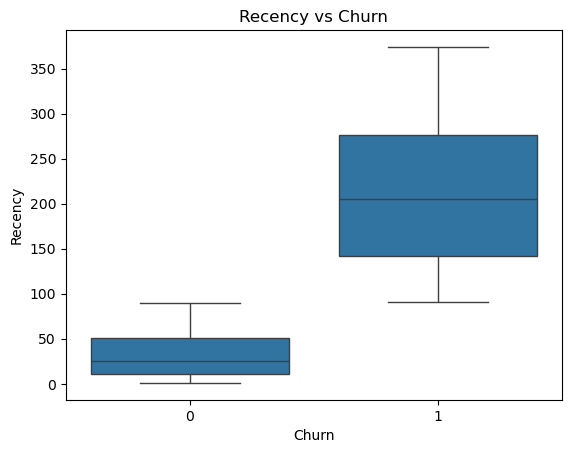

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x="Churn", y="Recency", data=df)
plt.title("Recency vs Churn")
plt.show()


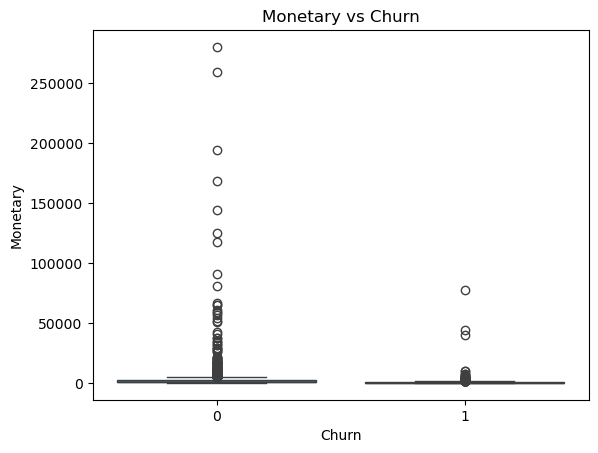

In [6]:
sns.boxplot(x="Churn", y="Monetary", data=df)
plt.title("Monetary vs Churn")
plt.show()


In [7]:
df.to_csv("../data/processed/churn_ready_data.csv", index=False)


In [8]:
import pandas as pd

df = pd.read_csv("../data/processed/churn_ready_data.csv")
df.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Cluster,PCA1,PCA2,Churn
0,12346.0,326,1,77183.60,1,1,5,115,Lost Customers,3,4.106623,5.433579,1
1,12347.0,2,7,4310.00,5,5,5,555,Champions,0,0.742411,-0.671300,0
2,12348.0,75,4,1797.24,2,4,4,244,At Risk,0,0.024802,-0.174954,0
3,12349.0,19,1,1757.55,4,1,4,414,Potential Loyalists,0,-0.028036,-0.735124,0
4,12350.0,310,1,334.40,1,1,2,112,Lost Customers,1,-1.235466,1.834946,1


In [9]:
features = [
    "Recency",
    "Frequency",
    "Monetary",
    "Cluster"
]

X = df[features]
y = df["Churn"]


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)



,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [13]:
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]


In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)


array([[723,   0],
       [  9, 353]])

In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       723
           1       1.00      0.98      0.99       362

    accuracy                           0.99      1085
   macro avg       0.99      0.99      0.99      1085
weighted avg       0.99      0.99      0.99      1085



In [16]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_prob)


1.0

In [17]:
import numpy as np

coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

coef_df


,Feature,Coefficient
0,Recency,11.288785
1,Frequency,0.425035
2,Monetary,-0.493483
3,Cluster,-0.553043


Train a Random Forest Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=42,
    class_weight="balanced"
)

rf_model.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [19]:
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]


In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, rf_pred)


array([[723,   0],
       [  0, 362]])

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, rf_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       723
           1       1.00      1.00      1.00       362

    accuracy                           1.00      1085
   macro avg       1.00      1.00      1.00      1085
weighted avg       1.00      1.00      1.00      1085



In [21]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, rf_prob)


1.0

In [23]:
import pandas as pd

feature_importance = pd.DataFrame({
    "Feature": features,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

feature_importance


,Feature,Importance
0,Recency,0.793617
3,Cluster,0.165409
1,Frequency,0.037358
2,Monetary,0.003616


In [24]:
model_results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "ROC_AUC": [
        roc_auc_score(y_test, y_prob),
        roc_auc_score(y_test, rf_prob)
    ]
})

model_results


,Model,ROC_AUC
0,Logistic Regression,1.0
1,Random Forest,1.0


In [25]:
df.loc[X_test.index, "Churn_Probability"] = rf_prob
df.to_csv("../data/processed/churn_predictions.csv", index=False)
